# **Data Loading**

In [1]:
import pandas as pd
import argparse
from typing import Dict, Tuple, List

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
UDDS_data = pd.read_csv("/content/drive/MyDrive/ReVolt code/UDDS")
UDDS_data.head()

,Unnamed: 0,Unnamed: 0.1,Degrees,Time,Speed,Energycons,EProp,E_Aux,HVAC,Power,Regen,SoC,driveCycle,city,weather
0,0,0,0.0,0.000000,0.0,NaN,0.0,5.35,4.2501,9.6001,0.0,100.000,UDDS,Seattle,Summer
1,1,1,0.1,0.000039,0.0,inf,0.0,5.35,4.2501,9.6001,0.0,100.000,UDDS,Seattle,Summer
2,2,2,0.2,0.555860,0.0,inf,0.0,5.35,4.2501,9.6001,0.0,100.000,UDDS,Seattle,Summer
3,3,3,0.3,5.500000,0.0,inf,0.0,5.35,4.2501,9.6001,0.0,99.995,UDDS,Seattle,Summer
4,4,4,0.4,9.702200,0.0,inf,0.0,5.35,4.2501,9.6001,0.0,99.991,UDDS,Seattle,Summer


In [4]:
UDDS_data.shape

(8882, 15)

# **Data Cleaning**

Let's add dummies for weather so it will give 0 for summer and 1 for winter, as it will be easier to segregate the data based on seasons for our analysis to compare and contrast.

In [5]:
# Creating a dummy variable for the variable 'city' and dropping the first one.
#city_dummy = pd.get_dummies(UDDS_data['city'],prefix='city',drop_first=False)
#Adding the results to the master dataframe
#UD_data = pd.concat([UDDS_data,city_dummy],axis=1)

# Creating a dummy variable for the variable 'weather' and dropping the first one.
weather_dummy = pd.get_dummies(UDDS_data['weather'],prefix='weather',drop_first=True)
#Adding the results to the master dataframe
UD_data = pd.concat([UDDS_data,weather_dummy],axis=1)

In [6]:
UD_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Degrees', 'Time', 'Speed', 'Energycons',
       'EProp', 'E_Aux', 'HVAC', 'Power', 'Regen', 'SoC', 'driveCycle', 'city',
       'weather', 'weather_Winter'],
      dtype='object')

Removing drivecycle and weather columns as we have already reproduced our data in such a way that one file is related to one drive cycle and we have our dummy for weather.

In [7]:
UD_data.drop(columns=['weather','driveCycle','Unnamed: 0','Unnamed: 0.1'],inplace=True)

In [8]:
UD_data.shape

(8882, 12)

Check for any null values :

In [9]:
UD_nocity_data = UD_data[['Degrees', 'Time', 'Speed', 'Energycons',
       'EProp', 'E_Aux', 'HVAC', 'Power', 'Regen', 'SoC','weather_Winter']]
df =UD_nocity_data.columns.to_series()[np.isnan(UD_nocity_data).any()]
df1 =UD_nocity_data.columns.to_series()[np.isinf(UD_nocity_data).any()]
print(df, df1)

Energycons    Energycons
dtype: object Energycons    Energycons
dtype: object


Only Energycons contain both Nan and inf values, so first we'll replace inf values with nan and check how much of the data will be effected.

In [10]:
UD_data.replace(np.inf, np.nan, inplace=True)

100* UD_data.isnull().sum() / UD_data.shape[0]

Degrees           0.000000
Time              0.000000
Speed             0.000000
Energycons        1.249719
EProp             0.000000
E_Aux             0.000000
HVAC              0.000000
Power             0.000000
Regen             0.000000
SoC               0.000000
city              0.000000
weather_Winter    0.000000
dtype: float64

Energycons consists of 1.2% data of nan values, when combined with 10 cities, so per city with a particular season, removing those values might effect the regression analysis. Hence let's just replace nan values with 0 and continue with the analysis.



In [11]:
UD_data.fillna(0,inplace = True)

In [12]:
UD_data.shape

(8882, 12)

In [13]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler() ##initialize the minmax scaler from sklearn
#norm_UD_data['Energycons'] = scaler.fit_transform(UD_data['Energycons'].values.reshape(-1,1)) ## fit transform on train data


In [14]:
UD_data.to_csv("UDDS_final.csv")

The resulting data set has been given the name UDDS_final.csv

# **Data Understanding**

Let's check how dependent are the variables on each other using correlation.

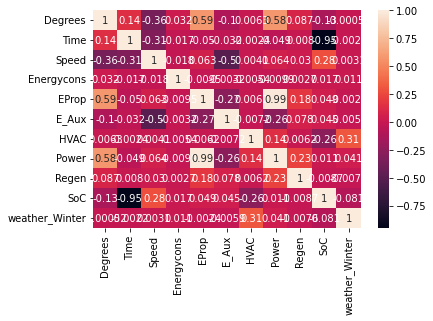

In [15]:
#plotting the heatmap for correlation
hm = sns.heatmap(UD_data.corr(), annot=True)

The heatmap suggest that power is dependent on Eprop stronger than that of how it is dependent on degrees. We can predict that this can be because the power is the summation of  E-prop,E-Aux & HVAC. Any other variable doesn't seem to much correlated to any other variable. 

# **Data Modeling**

Converting the data into Predictor and response sets. Where, the data in X, is used to regress on and the data is y is the dependent varibles and are true output varibles.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

from pandas.core.base import NoNewAttributesMixin


In [17]:
print(UD_data['weather_Winter'].unique())

[0 1]


splitting data into winter and summer as per seasons respectively

In [18]:
UD= UD_data.groupby('weather_Winter')
UDDS_winter = UD.get_group(UD_data['weather_Winter'].unique()[1])
UDDS_summer = UD.get_group(UD_data['weather_Winter'].unique()[0])

Train and test split for winter:

In [19]:

newUDDS_winter = UDDS_winter

UDX_winter = newUDDS_winter[['Degrees', 'Time', 'Speed','weather_Winter']]


UDY_winter = newUDDS_winter[['Energycons', 'EProp', 'E_Aux', 'HVAC',
       'Regen', 'SoC']]



Train and test data for summer: 

In [20]:
newUDDS_summer = UDDS_summer

UDX_summer = newUDDS_summer[['Degrees', 'Time', 'Speed','weather_Winter']]


UDY_summer = newUDDS_summer[['Energycons', 'EProp', 'E_Aux', 'HVAC',
       'Regen', 'SoC']]

# Linear Regression For MultiTarget Regression:
Applying Linear Regression model and checking the if the prediction is accurate.

### linear regression for winter of all the cities

In [21]:
UDDS_winter_linearmodel = LinearRegression()
# fit model
UDDS_winter_linearmodel.fit(UDX_winter, UDY_winter)

LinearRegression()

In [22]:
UDY_winter_pred = UDDS_winter_linearmodel.predict(UDX_winter)
r2_score( np.array(UDY_winter), UDY_winter_pred,multioutput='uniform_average')

0.2816329892934713

In [23]:
mean_absolute_error( UDY_winter, UDY_winter_pred)

4.89816725326858e+16

In [24]:
mean_absolute_percentage_error( UDY_winter, UDY_winter_pred)

4.7201732239766356e+30

In [25]:
mean_squared_error( UDY_winter, UDY_winter_pred)

4.534668207718808e+36

### Scaling and plotting for linear regression (winter)

As the values are too large, plotting our regression will become more difficult, therefore we will need to scale our values down.

In [26]:
scaler = MinMaxScaler() ##initialize the minmax scaler from sklearn
UDY_winter = scaler.fit_transform(UDY_winter) ## fit transform on train data
UDY_winter_pred = scaler.fit_transform(UDY_winter_pred)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


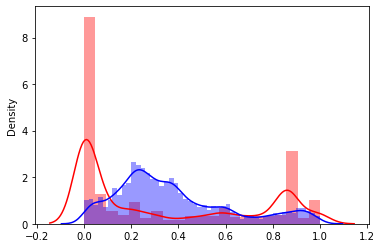

In [27]:
#plt.plot(UDY_winter, UDY_winter_pred, color="b")

ax1 = sns.distplot(UDY_winter, color="r", label="Actual Value")
sns.distplot(UDY_winter_pred, color="b", label="Fitted Values" , ax=ax1)

### linear regression for summer of all the cities

In [28]:
UDDS_summer_linearmodel = LinearRegression()
# fit model
UDDS_summer_linearmodel.fit(UDX_summer, UDY_summer)

LinearRegression()

In [29]:
UDY_summer_pred = UDDS_summer_linearmodel.predict(UDX_summer)
r2_score( np.array(UDY_summer), UDY_summer_pred,multioutput='uniform_average')

0.30400355271766283

In [30]:
mean_absolute_error( UDY_summer, UDY_summer_pred)

7619446.650131792

In [31]:
mean_absolute_percentage_error( UDY_summer, UDY_summer_pred)

7.508389844700193e+20

In [32]:
mean_squared_error( UDY_summer, UDY_summer_pred)

2.6533186867448244e+16

###Scaling values and plotting: linear regression graph (summer)

In [33]:
UDY_summer = scaler.fit_transform(UDY_summer) ## fit transform on train data
UDY_summer_pred = scaler.fit_transform(UDY_summer_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


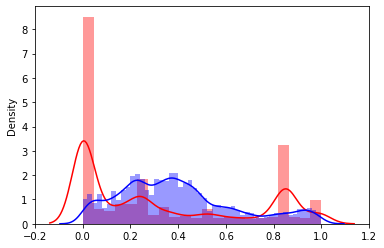

In [34]:
ax1 = sns.distplot(UDY_summer, color="r", label="Actual Value")
sns.distplot(UDY_summer_pred, color="b", label="Fitted Values" , ax=ax1)

### Conclusion for linear regression :

Clearly, linear regression is not an accurate model for both summer and winter data. My guess here is that the variables are not as dependent as they must be for a linear regression to work.

# **KNN for multioutput Regression**

### KNN for winter of all the cities

In [35]:
KNNmodel = KNeighborsRegressor()
# fit model
KNNmodel.fit(UDX_winter, UDY_winter)

KNeighborsRegressor()

In [36]:
UDDS_winter_KNNY_pred = KNNmodel.predict(UDX_winter)
r2_score( np.array(UDY_winter), UDDS_winter_KNNY_pred,multioutput='uniform_average')

0.6813187753006172

In [37]:
mean_absolute_error( UDY_winter, UDDS_winter_KNNY_pred)

0.045993722894824264

In [38]:
mean_absolute_percentage_error( UDY_winter, UDDS_winter_KNNY_pred)

17049029846159.533

In [39]:
mean_squared_error( UDY_winter, UDDS_winter_KNNY_pred)

0.014481403311705672

### Scaling and plotting for KNN (winter)

In [40]:
UDDS_winter_KNNY_pred = scaler.fit_transform(UDDS_winter_KNNY_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


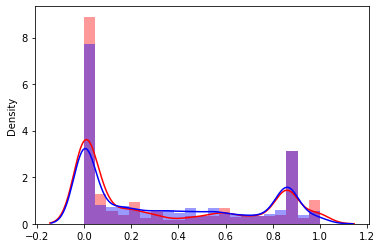

In [41]:
ax1 = sns.distplot(UDY_winter, color="r", label="Actual Value")
sns.distplot(UDDS_winter_KNNY_pred, color="b", label="Fitted Values" , ax=ax1)

### KNN for summer of all the cities

In [42]:
# fit model
KNNmodel.fit(UDX_summer, UDY_summer)

KNeighborsRegressor()

In [43]:
UDDS_summer_KNNY_pred = KNNmodel.predict(UDX_summer)
r2_score( np.array(UDY_summer), UDDS_summer_KNNY_pred,multioutput='uniform_average')

0.7853266018838486

In [44]:
mean_absolute_error( UDY_summer, UDDS_summer_KNNY_pred)

0.034613724828523464

In [45]:
mean_absolute_percentage_error( UDY_summer, UDDS_summer_KNNY_pred)

23868543403479.3

In [46]:
mean_squared_error( UDY_summer, UDDS_summer_KNNY_pred)

0.010358112427442326

### Scaling and plotting for KNN (summer)

In [47]:
UDDS_summer_KNNY_pred = scaler.fit_transform(UDDS_summer_KNNY_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


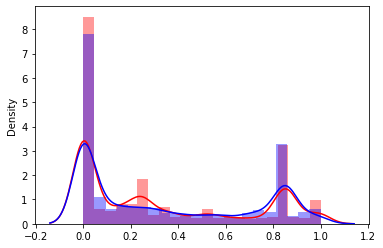

In [48]:
ax1 = sns.distplot(UDY_summer, color="r", label="Actual Value")
sns.distplot(UDDS_summer_KNNY_pred, color="b", label="Fitted Values" , ax=ax1)

### Conclusion for KNN :

KNN seems to be a better model for both summer and winter data when compared to that of linear regression. But, it is not the best model as a single model as it's accuracy is only about 78%.

# **Random Forest for multioutput Regression**


### Random forest for winter of all the cities

In [49]:
RFmodel = RandomForestRegressor()
# fit model
RFmodel.fit(UDX_winter, UDY_winter)

RandomForestRegressor()

In [50]:
UDDS_winter_RFY_pred = RFmodel.predict(UDX_winter)
r2_score( np.array(UDY_winter), UDDS_winter_RFY_pred,multioutput='uniform_average')

0.9484774767321311

In [51]:
mean_absolute_error( UDY_winter, UDDS_winter_RFY_pred)

0.018232208477030443

In [52]:
mean_absolute_percentage_error( UDY_winter, UDDS_winter_RFY_pred)

6024744976857.251

In [53]:
mean_squared_error( UDY_winter, UDDS_winter_RFY_pred)

0.0025005764736479607

### Scaling and plotting for Random forest (winter)

In [54]:
UDDS_winter_RFY_pred = scaler.fit_transform(UDDS_winter_RFY_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


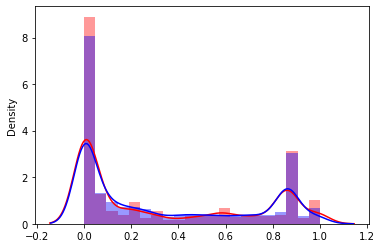

In [55]:
ax1 = sns.distplot(UDY_winter, color="r", label="Actual Value")
sns.distplot(UDDS_winter_RFY_pred, color="b", label="Fitted Values" , ax=ax1)

### Random forest for summer of all the cities

In [56]:
RFmodel.fit(UDX_summer, UDY_summer)

RandomForestRegressor()

In [57]:
UDDS_summer_RFY_pred = RFmodel.predict(UDX_summer)
r2_score( np.array(UDY_summer), UDDS_summer_RFY_pred,multioutput='uniform_average')

0.9588627978234161

In [58]:
mean_absolute_error( UDY_summer, UDDS_summer_RFY_pred)

0.014818332372798206

In [59]:
mean_absolute_percentage_error( UDY_summer, UDDS_summer_RFY_pred)


10176307891875.416

In [60]:
mean_squared_error( UDY_summer, UDDS_summer_RFY_pred)

0.00208500463000352

### Scaling and plotting for Random forest (summer)

In [61]:
UDDS_summer_RFY_pred = scaler.fit_transform(UDDS_summer_RFY_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


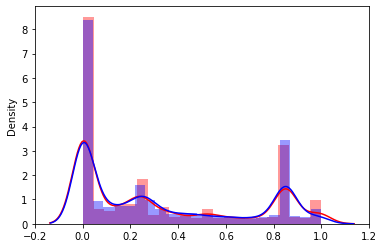

In [62]:
ax1 = sns.distplot(UDY_summer, color="r", label="Actual Value")
sns.distplot(UDDS_summer_RFY_pred, color="b", label="Fitted Values" , ax=ax1)

### Conclusion for KNN :
Random forest seems to be the best model for the data with 95% accuracy and the graph shows how accurate the predicted values are to that of actual values.

# **MultiOutput Regression using XGBoost:**

### XGBoost for winter of all the cities

In [63]:
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:linear')).fit(UDX_winter, UDY_winter)
UDDS_winter_XGBY_pred= multioutputregressor.predict(UDX_winter)

[20:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [64]:
r2_score( np.array(UDY_winter), UDDS_winter_XGBY_pred ,multioutput='uniform_average')

0.7479037877297924

In [65]:
mean_absolute_error( UDY_winter, UDDS_winter_XGBY_pred)

0.05412001569696892

In [66]:
mean_absolute_percentage_error( UDY_winter, UDDS_winter_XGBY_pred)

16560364500627.771

In [67]:
mean_squared_error( UDY_winter, UDDS_winter_XGBY_pred)

0.014984751526710818

### Scaling and plotting for XGBoost (winter)

In [68]:
UDDS_winter_XGBY_pred = scaler.fit_transform(UDDS_winter_XGBY_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


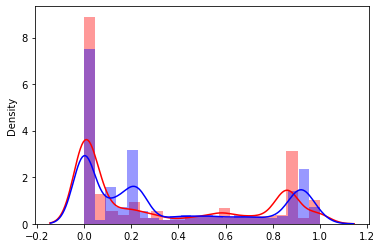

In [69]:
ax1 = sns.distplot(UDY_winter, color="r", label="Actual Value")
sns.distplot(UDDS_winter_XGBY_pred, color="b", label="Fitted Values" , ax=ax1)

### XGBoost for summer of all the cities

In [70]:
multioutputregressor.fit(UDX_summer, UDY_summer)
UDDS_summer_XGBY_pred= multioutputregressor.predict(UDX_summer)

[20:51:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [71]:
r2_score( np.array(UDY_summer), UDDS_summer_XGBY_pred ,multioutput='uniform_average')

0.7423261252177338

In [72]:
mean_absolute_error( UDY_summer, UDDS_summer_XGBY_pred)

0.04476820354232913

In [73]:
mean_absolute_percentage_error( UDY_summer, UDDS_summer_XGBY_pred)


24347634128085.293

In [74]:
mean_squared_error( UDY_summer, UDDS_summer_XGBY_pred)

0.011934309566926803

### Scaling and plotting for XGBoost (summer)

In [75]:
UDDS_summer_XGBY_pred = scaler.fit_transform(UDDS_summer_XGBY_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


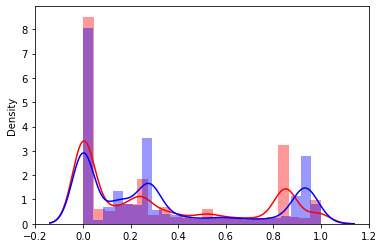

In [76]:
ax1 = sns.distplot(UDY_summer, color="r", label="Actual Value")
sns.distplot(UDDS_summer_XGBY_pred, color="b", label="Fitted Values" , ax=ax1)

###Conclusion for XGBoost :
XGBoost model is almost like KNN model with accuracy of around the same values for both winter and summer. 